In [1]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from scipy.special import p_roots
from scipy.special import roots_jacobi, jacobi, gamma
from scipy.integrate import trapz, simps, quadrature, quad

tf.config.run_functions_eagerly(True)

DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

path = '/Users/pc/Desktop/Maxwell Electrodynamics/Output_Real(Normal)_Time/'

2023-08-02 14:44:40.048139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set up the known constants
mu      = 1
epsilon = 1
xi      = 4

# Calculated Constants
c   = 1 / np.sqrt(mu * epsilon)
a   = c * xi
eta = abs(np.sqrt(mu / epsilon))

def D(t):
    t_reference = t * 10
    benchmark   = 0.4 * 10
    condition   = tf.greater(t_reference, benchmark)
    result      = tf.where(condition, 0.338, 0.675)
    return result

s     = lambda t: abs(tf.math.sqrt(xi * D(t) / (2 * epsilon)))
gamma = lambda t: abs(tf.math.sqrt(mu * epsilon * (s(t) ** 2) + (xi ** 2)))


In [3]:
# Set number of data points
N_0 = 200 # for t = 0
N_r = 10000
N_b = 200 # for t = 1
N_integration = 200 # for the partition of integration

# Set boundary
tmin, tmax = 0., 1.
xmin, xmax = 0., 2 * np.pi
lb = tf.constant([tmin, xmin], dtype=DTYPE)
jb = tf.constant([tmax, xmax], dtype=DTYPE)

tf.random.set_seed(0)

t_0 = tf.ones((N_0,1), dtype=DTYPE) * lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], jb[1], dtype=DTYPE)

t_N = tf.ones((N_b,1), dtype=DTYPE) * jb[0]
x_N = tf.random.uniform((N_b,1), lb[1], jb[1], dtype=DTYPE)

X_0 = tf.concat([t_0, x_0], axis=1)
X_N = tf.concat([t_N, x_N], axis=1)

X_boundary = [X_0, X_N]


In [4]:
# Define the Integration
def gauss_lobatto_jacobi_weights(q):
    w = []
    x = roots_jacobi(q - 2, 1, 1)[0] 
    # weight at x
    w  = 2 / ((q-1) * q * jacobi(q - 1, 0, 0)(np.array(x )) ** 2)
    # weight at xmin
    wl = 2 / ((q-1) * q * jacobi(q - 1, 0, 0)(np.array(-1)) ** 2)
    # weight at xmax
    wr = 2 / ((q-1) * q * jacobi(q - 1, 0, 0)(np.array(+1)) ** 2)
    w = np.append(w, wr) # write weight of xmax on the right of weight of x
    w = np.append(wl, w) # write weight of xmin on the left  of weight of x
    x = np.append(x, 1) # write xmax on the right of x
    x = np.append(0, x) # write xmin on the left of x
    return [x, w]

def gauss_lobatto_jacobi_quadrature1D(num_points, a, b):
    roots, weights = gauss_lobatto_jacobi_weights(num_points)
    X = (b - a) / 2 * (roots + 1) + a
    X = tf.constant(X)
    return X, tf.constant(weights)

def gauss_legendre(u, t):
    roots, weights = gauss_lobatto_jacobi_quadrature1D(N_integration, tf.zeros((N_r, 1)), t)    
    first  = tf.math.reduce_sum(np.matmul(u(roots), weights))
    second = tf.math.reduce_sum((roots[-1, -1] - roots[0, 0]) / 2)
    return first.numpy() * second.numpy()

def gauss_legendre_kernel(u, t):
    roots, weights = gauss_lobatto_jacobi_quadrature1D(N_integration, tf.zeros((N_r, 1)), t)
    return roots

### Governing Equation

$$\frac{\partial j}{\partial t} + \frac{\eta D}{2}(j + k_1 *_t j) = \frac{\eta D}{2} ( j_0 + k_1 *_t j_0) + D E_{x0}(x,0,t)$$


$$
j_0(x,t) = 2 e^{i\xi x - s_0 t}, \\
E_{x0} (x,0,t) = \frac{\gamma_0}{\epsilon s_0} e^{i\xi x - s_0 t} \\
(k_1 *_t j )(x,t) = \int_0^t k_1(t') j(x,t-t') dt' \\
k_1(t') = \int_0^{t'} \frac{a}{m} J_1(am) dm
$$

$$\frac{\partial j}{\partial t} + \frac{\eta D}{2}(j - 2 e^{i\xi x - s_0 t}) + \frac{\eta D}{2} \cdot \int_0^t\int_0^{t'} \frac{a}{m} J_1(am) dm \cdot (j(x, t - t') - 2 e^{i\xi x - s_0 (t - t')}) dt' = D \frac{\gamma_0}{\epsilon s_0} e^{i\xi x - s_0 t} $$

$$
m \in (0, t') \\
t' \in (0, t) \\
z \in (t, 0)
$$

Change of variables: $z = t - t' \Rightarrow t' = t - z, dt' = -dz$

$$
\int_0^t k_1(t')j(x, t-t')dt' \\
\Rightarrow - \int_0^t k_1(t - z)j(x, z)dz
$$

$$
j(x, z) = Reverse(j(x, t)) \\
k_1(t - z) = \int_0^{t-z} \frac{a}{m} J_1(am)dm
$$

$$\Rightarrow \frac{\partial j}{\partial t} + \frac{\eta D}{2}(j - 2 e^{i\xi x - s_0 t}) - \frac{\eta D}{2} \cdot \int_0^t\int_0^{t-z} \frac{a}{m} J_1(am) dm \cdot (j(x, z) - 2 e^{i\xi x - s_0 (z)}) dz = D \frac{\gamma_0}{\epsilon s_0} e^{i\xi x - s_0 t} $$

$$\Rightarrow \frac{\partial j}{\partial t} + \frac{\eta D}{2}(j - 2 \cos(\xi x - s t)) - \frac{\eta D}{2} \cdot \int_t^0\int_t^0 \frac{a}{z} J_1(az) dz \cdot Inv(j - 2  \cos(\xi x - s t)) dz = D \frac{\gamma_0}{\epsilon s_0}  \cos(\xi x - s_0 t) $$

In [5]:
def real_residual(x, t, j, j_t):
    
    def LHS_real(x, t, j, j_t):
        z = tf.random.uniform((N_r, 1), t, tf.zeros(t.shape), dtype=DTYPE)
        k1_int = lambda z: gauss_legendre_kernel((a / z) * tf.math.special.bessel_j1(a * z), z)
        j_new  = lambda z: tf.reverse((j - 2 * tf.cos(xi * x - s(t) * z)), [-1])
        k2_int = gauss_legendre_kernel(k1_int(z) * j_new(z), z)
        return j_t + (eta * D(t) / 2) * (j - 2 * tf.cos(xi * x - s(t) * t)) - (eta * D(t) / 2) * k2_int
    
    def RHS_real(x, t):
        return - (D(t) * gamma(t) / (epsilon * s(t))) * tf.sin(xi * x - s(t) * t)
    return LHS_real(x, t, j, j_t) - RHS_real(x, t)


In [6]:
# Initial Condition for j(x, t)
def j_initial_real(x, t):
    return 2 * tf.cos(xi * x - s(t) * t)
j_initial_value_real = j_initial_real(x_0, t_0)
j_end_value_real     = j_initial_real(x_N, t_N)


#### Plot the Collocation Points

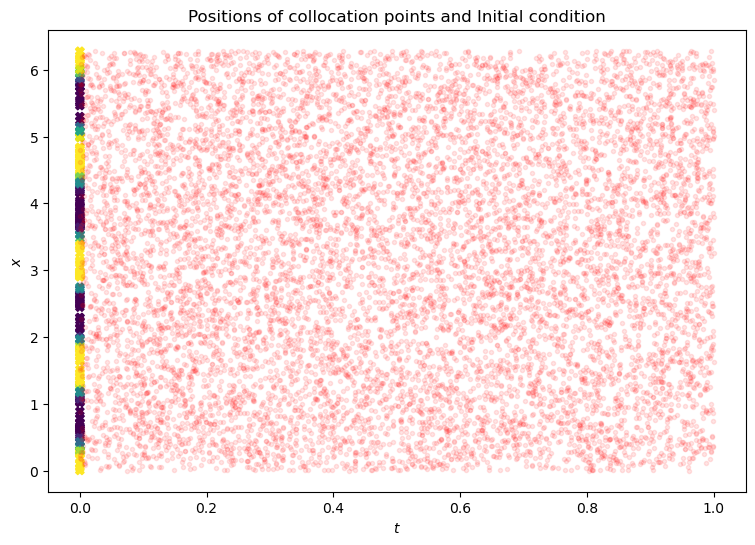

In [7]:
# Define the collocation points
t_r = tf.random.uniform((N_r,1), lb[0], jb[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], jb[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Plot the collocation points
fig = plt.figure(figsize=(9, 6))
plt.scatter(t_0, x_0, c = j_initial_value_real, marker = 'X', vmin = -1, vmax = 1)
plt.scatter(t_r, x_r, c = 'r', marker = '.', alpha = 0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and Initial condition');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

In [8]:
def init_model(W, H, activation_function):
    """
    W = num_hidden_layers     = 4 in default;
    H = num_neurons_per_layer = 8 in default;
    activation_function       = 'tanh' in default;
    """
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(2))
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(jb - lb) - 1.0)
    model.add(scaling_layer)
    for _ in range(W):
        model.add(tf.keras.layers.Dense(H,
            activation = tf.keras.activations.get(activation_function),
            kernel_initializer = 'glorot_normal'))
    model.add(tf.keras.layers.Dense(1))
    return model

In [9]:
def get_r(model, X_r):
    
    with tf.GradientTape(persistent=True) as tape:
        t, x = X_r[:, 0:1], X_r[:, 1:2]
        tape.watch(t)
        tape.watch(x)
        j = model(tf.stack([t[:,0], x[:,0]], axis=1))
        j_t  = tape.gradient(j, t)

    del tape
    return real_residual(x, t, j, j_t)

In [10]:
mse = tf.keras.losses.MeanSquaredError()

def compute_loss(model, X_r, X_boundary):
    r_real = get_r(model, X_r)
    loss_region_real  = mse(r_real, tf.zeros_like(r_real)).numpy()
    loss_initial_real = mse(j_initial_value_real, model_real(X_boundary[0]))
    loss_end_real     = mse(j_end_value_real, model_real(X_boundary[1]))
    loss_real = loss_region_real + loss_initial_real + loss_end_real
    return loss_real

In [11]:
def get_grad(model, X_r, X_boundary, j_initial_value):
    with tf.GradientTape(persistent = True) as tape:
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_boundary)
    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [12]:
# Set up meshgrid
N_mesh = 500
tspace = np.linspace(lb[0], jb[0], N_mesh + 1)
xspace = np.linspace(lb[1], jb[1], N_mesh + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

def plot_NN(model_real, epochs):
    # Determine predictions of u(t, x)
    jpred_real = model_real(tf.cast(Xgrid, DTYPE))
    j_NN_real = jpred_real.numpy().reshape(N_mesh + 1, N_mesh + 1)

    fig = plt.figure(figsize=(9,6))
    plt.pcolormesh(X, T, j_NN_real)
    plt.colorbar()
    plt.savefig(path + 'Real/Heatmap NN sol_Real epoches = %s'%epochs, bbox_inches='tight', dpi=300);
    
    # Real Surface plot of solution u(t,x)
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, T, j_NN_real, cmap='viridis');
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$j_\\theta(t,x)$')
    ax.set_title('NN Solution');
    plt.savefig(path + 'Real/NN sol_Real epoches = %s'%epochs, bbox_inches='tight', dpi=300);
    
    # Error plot for real solution
    def Exact_sol_real(x, t):
        return 2 * np.cos(xi * x - s(t) * t)
    j_exact_real = Exact_sol_real(X, T)
    j_error_real = j_NN_real - j_exact_real
    
    fig = plt.figure(figsize=(9,6))
    plt.pcolormesh(X, T, j_error_real)
    plt.colorbar()
    plt.savefig(path + 'Errors/Heatmap NN sol_Real epoches = %s'%epochs, bbox_inches='tight', dpi=300)
    
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, T, j_error_real, cmap='viridis');
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$j_\\theta(t,x)$')
    ax.set_title('NN Solution Errors (Real)');
    plt.savefig(path + 'Errors/NN Error epoches = %s'%epochs, bbox_inches='tight', dpi=300);
    

/Users/pc/anaconda3/lib/python3.10/site-packages/scipy/special/_orthogonal.py:370: RuntimeWarning: invalid value encountered in double_scalars
  hn *= _gam(n + beta + 1.0) / _gam(n + 1) / _gam(n + ab1)
/Users/pc/anaconda3/lib/python3.10/site-packages/scipy/special/_orthogonal.py:371: RuntimeWarning: invalid value encountered in double_scalars
  kn = _gam(2 * n + ab1) / 2.0**n / _gam(n + 1) / _gam(n + ab1)


Iteration 00000: Real loss = 5.96325588e+00
Iteration 00100: Real loss = 6.31602812e+00
Iteration 00200: Real loss = 6.48947906e+00
Iteration 00300: Real loss = 6.48816109e+00
Iteration 00400: Real loss = 6.48437881e+00
Iteration 00500: Real loss = 6.48124743e+00


/var/folders/5j/937d92fj6mb3d4_kbhlhjrfr0000gn/T/ipykernel_63401/1127550072.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(9,6))



Computation time: 115.77783608436584 seconds


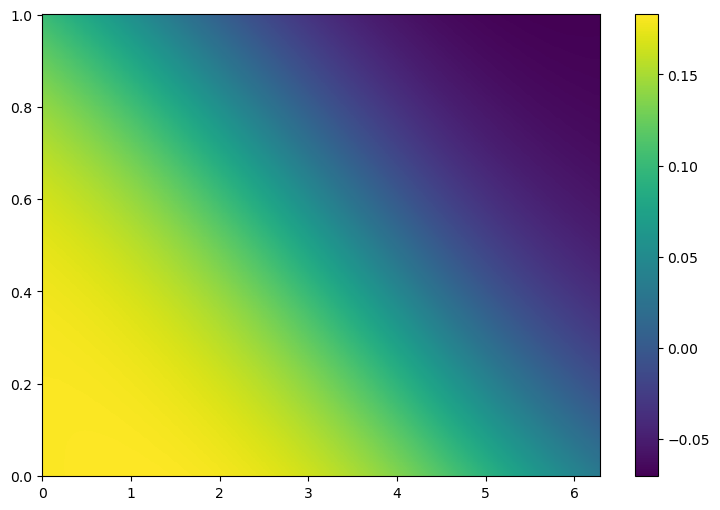

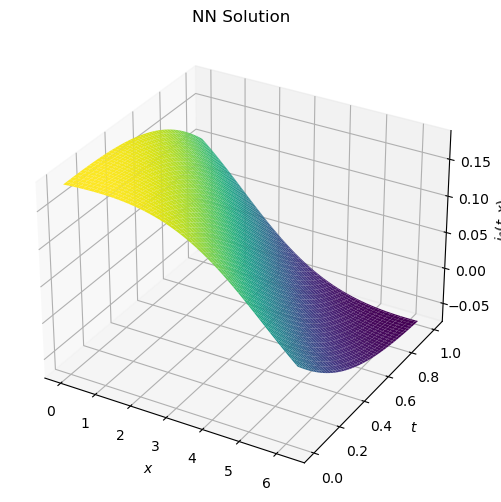

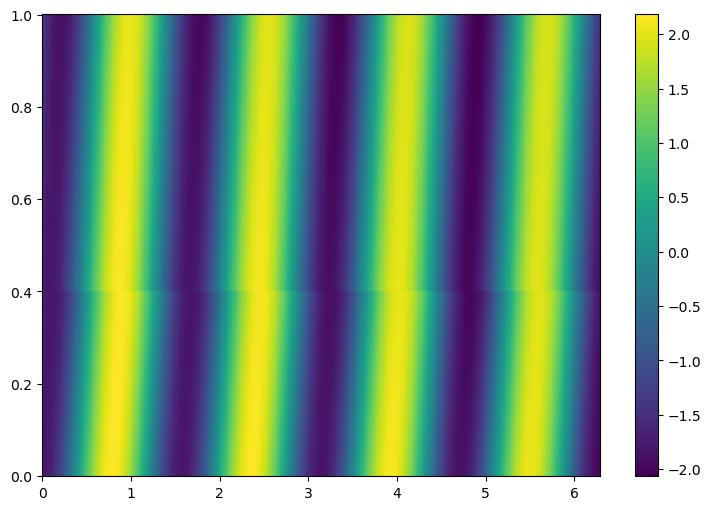

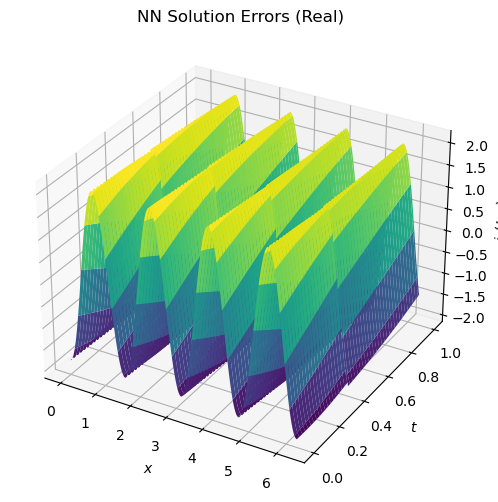

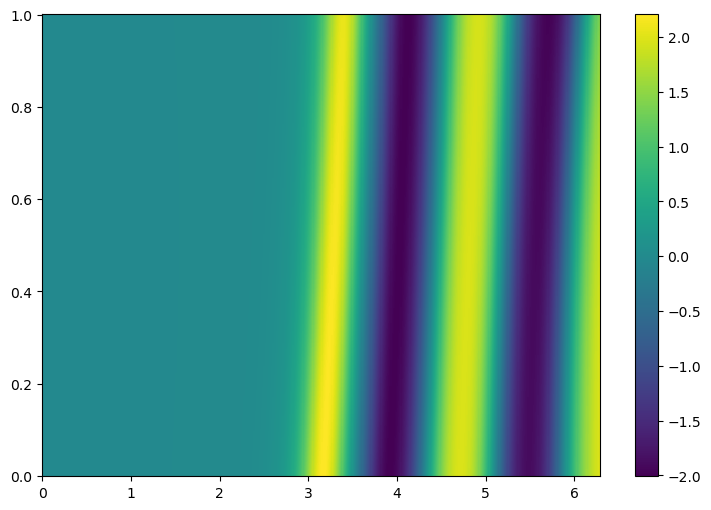

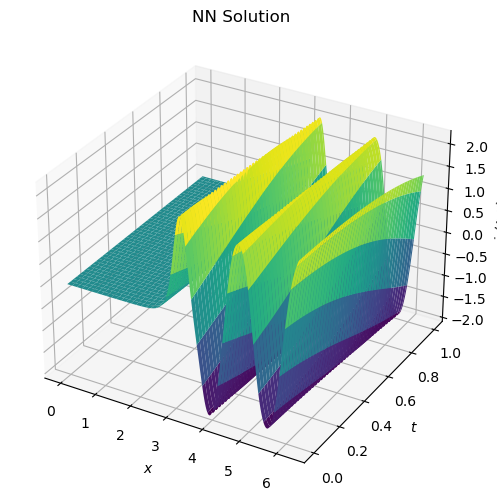

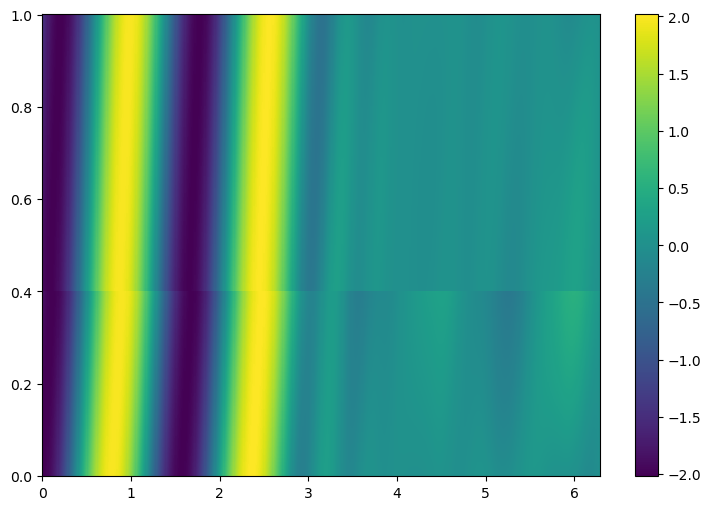

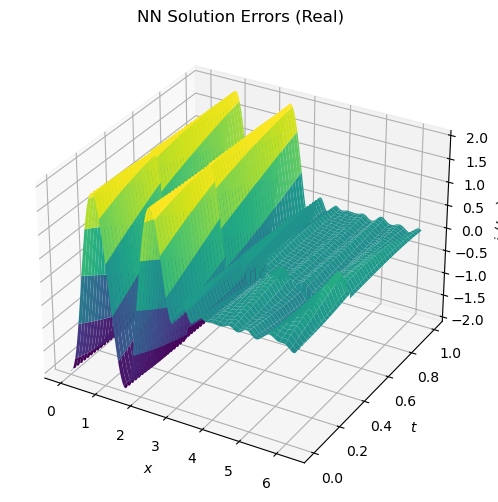

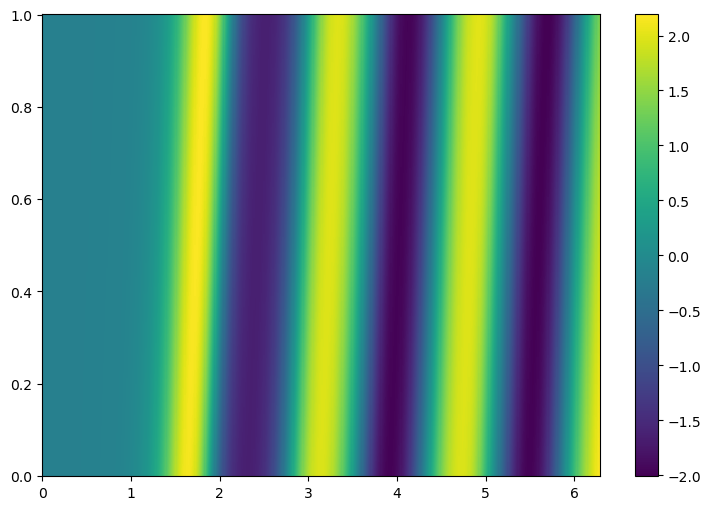

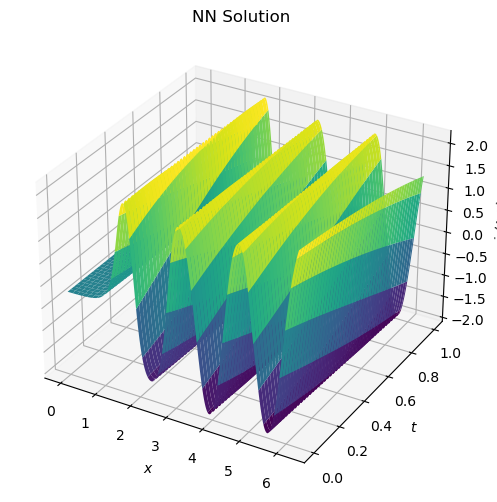

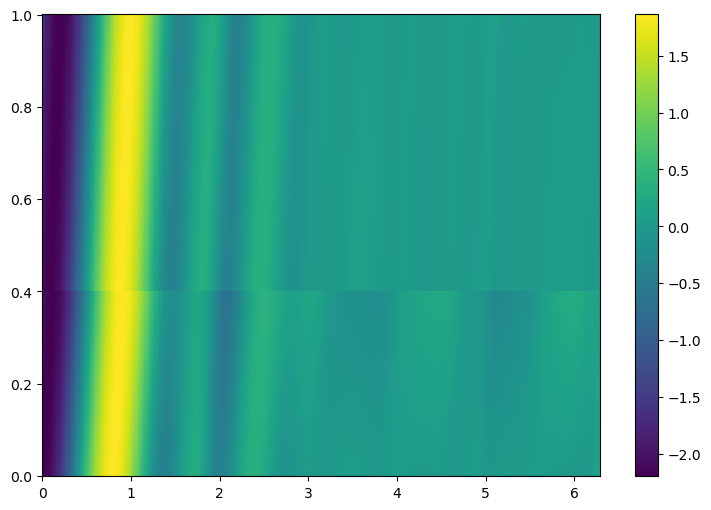

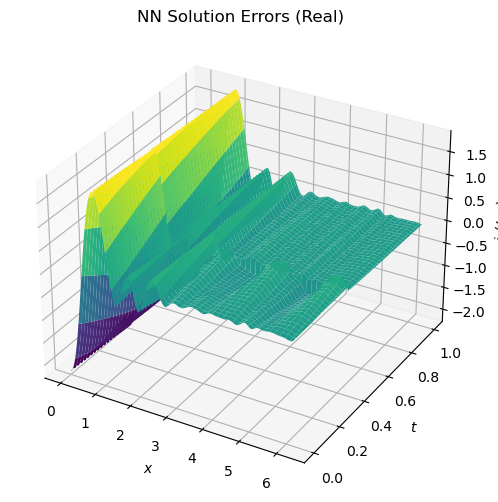

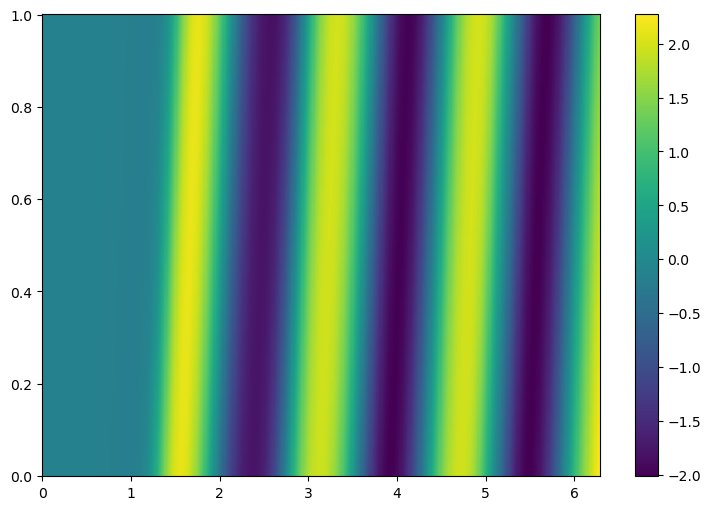

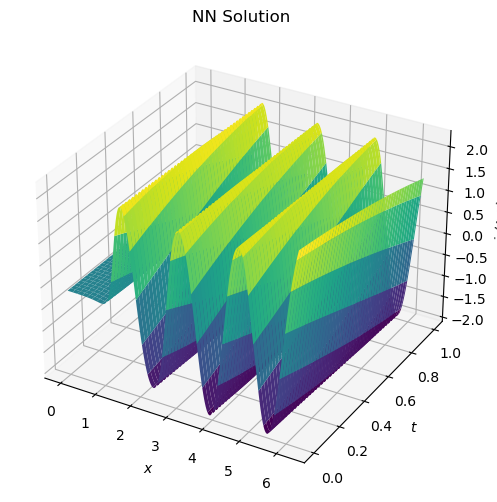

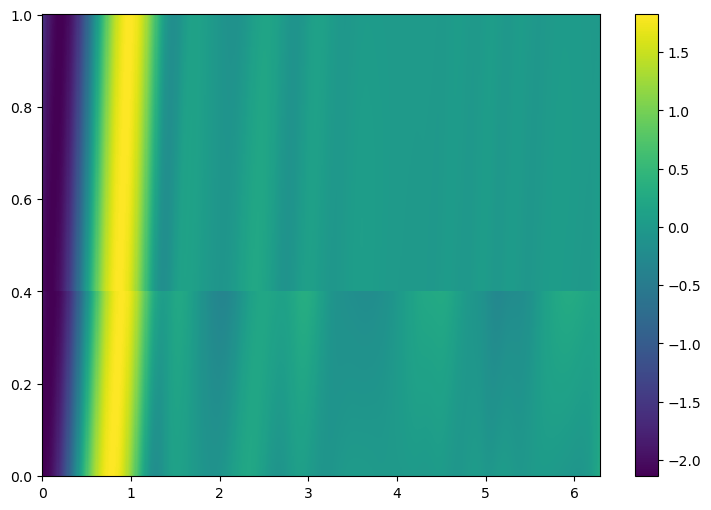

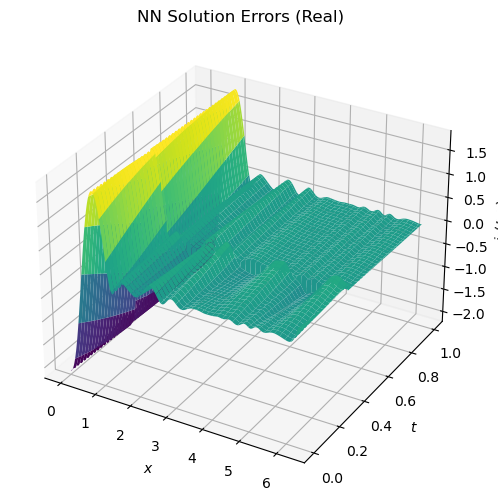

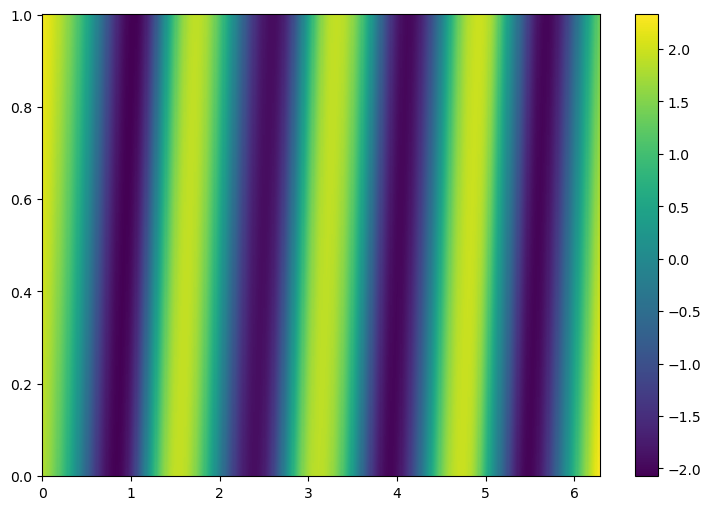

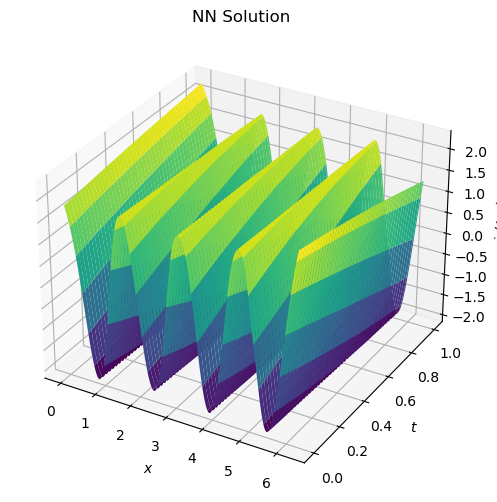

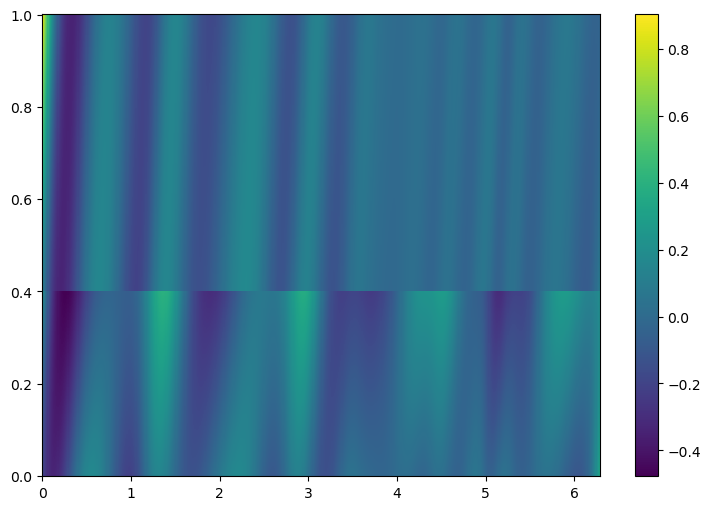

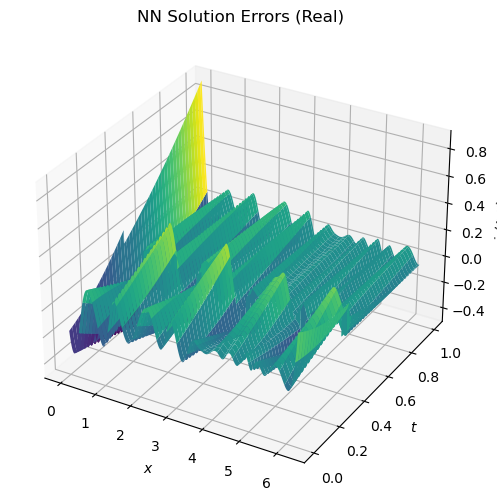

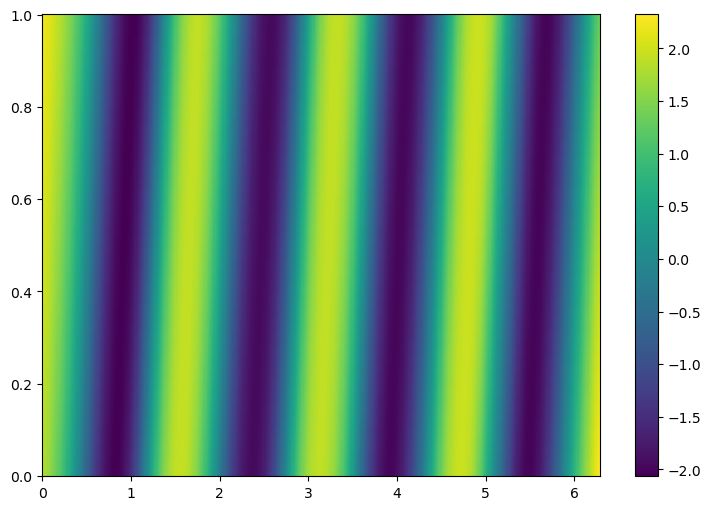

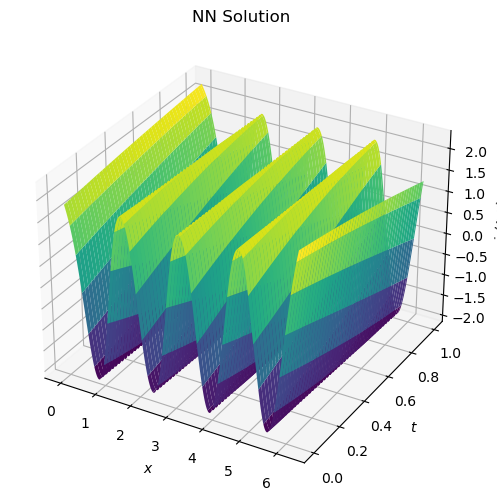

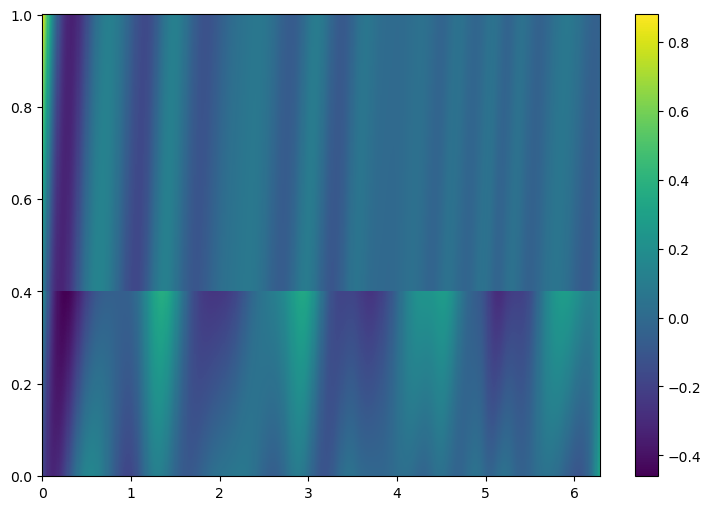

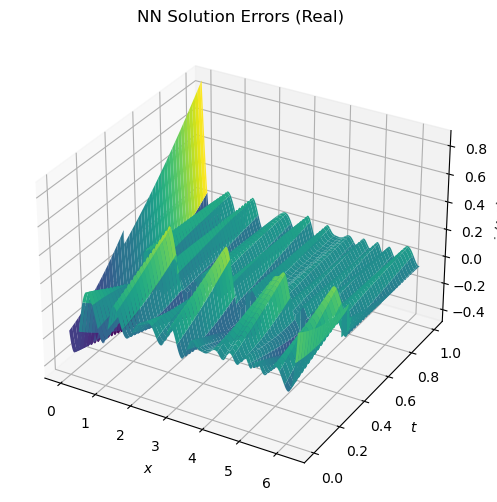

In [13]:
model_real = init_model(W = 4, H = 8, activation_function = 'tanh')
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 2000], [1e-2,1e-3,5e-4])
optim_real = tf.keras.optimizers.Adam(learning_rate=lr)

from time import time
@tf.function
def train_step(model_output, optimizer, initial_value):
    losses, grad_theta_real = get_grad(model_output, X_r, X_boundary, initial_value)
    optimizer.apply_gradients(zip(grad_theta_real, model_output.trainable_variables))
    return losses

epochs = 500
hist_real = []
t0     = time()

for i in range(epochs + 1):
    loss_real = train_step(model_real, optim_real, j_initial_value_real)
    loss_real, grad_theta_real = get_grad(model_real, X_r, X_boundary, j_initial_value_real)
    optim_real.apply_gradients(zip(grad_theta_real, model_real.trainable_variables))
    hist_real.append(loss_real.numpy())
    if i % 100 == 0:
        print('Iteration {:05d}: Real loss = {:10.8e}'.format(i, loss_real))
        plot_NN(model_real, i)
        
print('\nComputation time: {} seconds'.format(time() - t0))

### Plot and Compare with the exact solution

$$
f(x, t) = 2 \cdot e^{i\xi x - s_0 t}
$$

$$
f(x, t) = 2 \cdot (\cos(\xi x - s t) + i \cdot \sin(\xi x - s t))
$$

$$
\Rightarrow f(x, 0) = 2 \cdot (\cos(\xi x) + i \cdot \sin(\xi x)) \\
\Rightarrow f(x, 1) = 2 \cdot (\cos(\xi x - s) + i \cdot \sin(\xi x - s))
$$

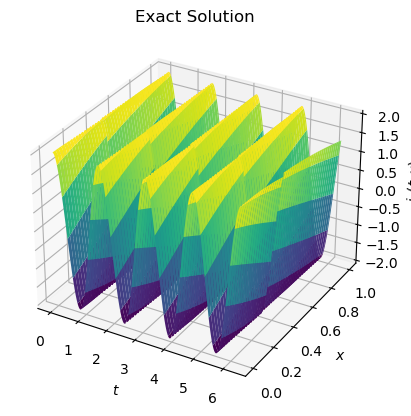

In [14]:
def Exact_sol(x, t):
    return 2 * np.cos(xi * x - s(t) * t)
j_exact = Exact_sol(X, T)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, j_exact, cmap='viridis')
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$j_\\theta(t,x)$')
ax.set_title('Exact Solution');
plt.show()

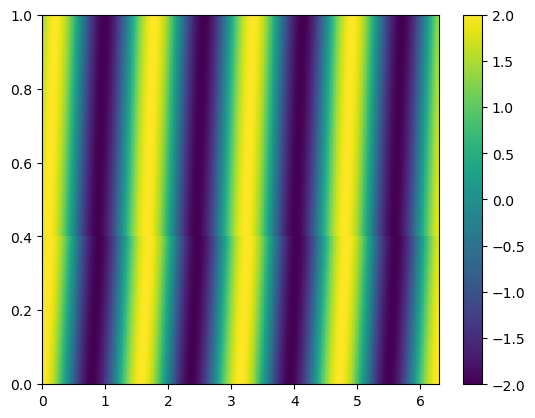

In [15]:
Z = np.array(j_exact).reshape(len(T), len(X))
plt.pcolormesh(X, T, Z)
plt.colorbar()
plt.show()

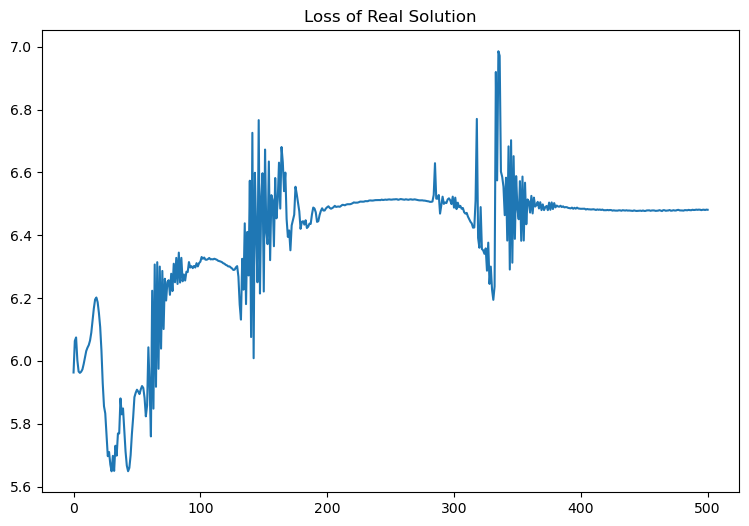

In [16]:
# Plot the losses of the output
L = len(hist_real)
epochs_axes = list(i for i in range(L))
fig = plt.figure(figsize=(9,6))
plt.plot(epochs_axes, hist_real)
plt.title('Loss of Real Solution')
plt.savefig(path + 'Loss of Solution')
plt.show()